<a href="https://colab.research.google.com/github/sammainahkinya1404/A-novel-detection-method-based-on-DETR-for-drone-aerial-images/blob/main/Drone_Aerial_Images_Detection_Using_DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import os
# import json
# import urllib.request
# from zipfile import ZipFile
# from pathlib import Path


In [2]:
# # function to downlaod from github extract images from zip file
# def download_extract_images(urls, extract_dir):
#     os.makedirs(extract_dir, exist_ok=True)
#     for url in urls:
#         file_name = url.split('/')[-1]
#         file_path = os.path.join(extract_dir, file_name)
#         urllib.request.urlretrieve(url, file_path)
#         with ZipFile(file_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_dir)
#         os.remove(file_path)

In [3]:
# # Function to convert annotations of the Images into COCO format
# def convert_annotations_to_coco_format(annotation_dir, output_dir):
#     os.makedirs(output_dir, exist_ok=True)
#     for file_name in os.listdir(annotation_dir):
#         if file_name.endswith('.txt'):
#             annotations = []
#             image_id = 0
#             with open(os.path.join(annotation_dir, file_name), 'r') as f:
#                 for line in f.readlines():
#                     values = line.strip().split()
#                     if len(values) > 0:
#                         category_id = int(values[0])
#                         bbox = list(map(float, values[1:]))
#                         annotations.append({
#                             "id": len(annotations),
#                             "image_id": image_id,
#                             "category_id": category_id,
#                             "bbox": bbox,
#                             "area": bbox[2] * bbox[3],
#                             "iscrowd": 0
#                         })
#             coco_format = {
#                 "images": [{"id": 0, "file_name": file_name.replace('.txt', '.jpg')}],
#                 "annotations": annotations,
#                 "categories": [{"id": 0, "name": "object"}]
#             }
#             output_file_path = os.path.join(output_dir, file_name.replace('.txt', '.json'))
#             with open(output_file_path, 'w') as f:
#                 json.dump(coco_format, f)

In [4]:
# # Define paths to store Data Images
# dataset_root = Path('/content/drive/MyDrive/Colab Notebooks/')
# download_dir = dataset_root / "downloaded_images"
# annotation_dir = dataset_root / "annotations"
# output_dir = dataset_root / "coco_annotations"


In [5]:
# annotation_dir = dataset_root / "annotations"
# os.makedirs(annotation_dir, exist_ok=True)  # Ensure the annotations directory exists
# output_dir = dataset_root / "coco_annotations"

In [6]:
# # Define URLs for the data
# urls = [
#     'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-train.zip',
#     'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-val.zip',
#     'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-dev.zip',
#     'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-challenge.zip'
# ]


In [7]:
# Download and extract images
# download_extract_images(urls, download_dir)

In [8]:



# # Convert annotations to COCO format
# convert_annotations_to_coco_format(annotation_dir, output_dir)


The Tasks Was Trained using The Orignal DETR model,which is What am Going to do,here is the Bulding Blocks of the Original DETR:


**1.ResNet-50 Backbone**



**2.Transformer Encoder**


**3.Transformer Decoder**

**4.Prediction Feed Forward Network[FFN]**

In [1]:
# Install all Libraries Needed
!pip install -q datasets transformers  pytorch_lightning supervision evaluate timm albumentations

In [22]:
!pip install scipy


In [7]:
# !pip show pydantic

In [25]:
# All Required Libraries
import torchvision
import os
import torch,torchvision
import supervision as sv
import transformers
import pytorch_lightning
import numpy as np
import random
import pydantic
from google.colab.patches import cv2_imshow
import cv2
# import supervisely_lib as sv

# from supervisely.annotation import Detections






In [12]:
# Define a simple image processor function
def image_processor(images, annotations, return_tensors):
    # Resize images to a fixed size (e.g., 224x224)
    resized_images = torchvision.transforms.Resize((224, 224))(images)

    # Convert annotations to a numpy array
    annotations_array = np.array([list(map(int, ann.split(','))) for ann in annotations.split('\n') if ann.strip()])

    # Convert annotations to PyTorch tensor
    annotations_tensor = torch.tensor(annotations_array, dtype=torch.float32)

    if return_tensors == "pt":
        return {"images": resized_images, "annotations": annotations_tensor}
    else:
        return {"images": resized_images.numpy(), "annotations": annotations_array}

TRAIN_IMAGE_DIRECTORY = "/content/drive/MyDrive/Colab_Notebooks/downloaded_images/VisDrone2019-DET-train/images"
TRAIN_ANNOTATION_DIRECTORY = "/content/drive/MyDrive/Colab_Notebooks/downloaded_images/VisDrone2019-DET-train/annotations"

VAL_IMAGE_DIRECTORY = "/content/drive/MyDrive/Colab_Notebooks/downloaded_images/VisDrone2019-DET-val/images"
VAL_ANNOTATION_DIRECTORY = "/content/drive/MyDrive/Colab_Notebooks/downloaded_images/VisDrone2019-DET-val/annotations"

TEST_IMAGE_DIRECTORY = "/content/drive/MyDrive/Colab_Notebooks/downloaded_images/VisDrone2019-DET-test-dev/images"
TEST_ANNOTATION_DIRECTORY = "/content/drive/MyDrive/Colab_Notebooks/downloaded_images/VisDrone2019-DET-test-dev/annotations"

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        annotation_directory_path: str,
        image_processor,
        train: bool = True
    ):
        self.image_directory_path = image_directory_path
        self.annotation_directory_path = annotation_directory_path
        self.image_processor = image_processor
        self.train = train
        self.image_list = os.listdir(image_directory_path)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = os.path.join(self.image_directory_path, image_name)
        annotation_path = os.path.join(self.annotation_directory_path, os.path.splitext(image_name)[0] + ".txt")
        images = torchvision.io.read_image(image_path)
        with open(annotation_path, 'r') as file:
            annotations = file.read()

        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["images"].squeeze()
        target = encoding["annotations"]

        return pixel_values, target


# Initialize datasets
TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_IMAGE_DIRECTORY,annotation_directory_path=TRAIN_ANNOTATION_DIRECTORY,image_processor=image_processor,
    train=True
)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_IMAGE_DIRECTORY,
    annotation_directory_path=VAL_ANNOTATION_DIRECTORY,
    image_processor=image_processor,
    train=False
)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_IMAGE_DIRECTORY,
    annotation_directory_path=TEST_ANNOTATION_DIRECTORY,
    image_processor=image_processor,
    train=False
)

print("Number of training examples:", len(TRAIN_DATASET.image_list))
print("Number of validation examples:", len(VAL_DATASET.image_list))
print("Number of test examples:", len(TEST_DATASET.image_list))


Number of training examples: 6471
Number of validation examples: 548
Number of test examples: 1610


Image #4483


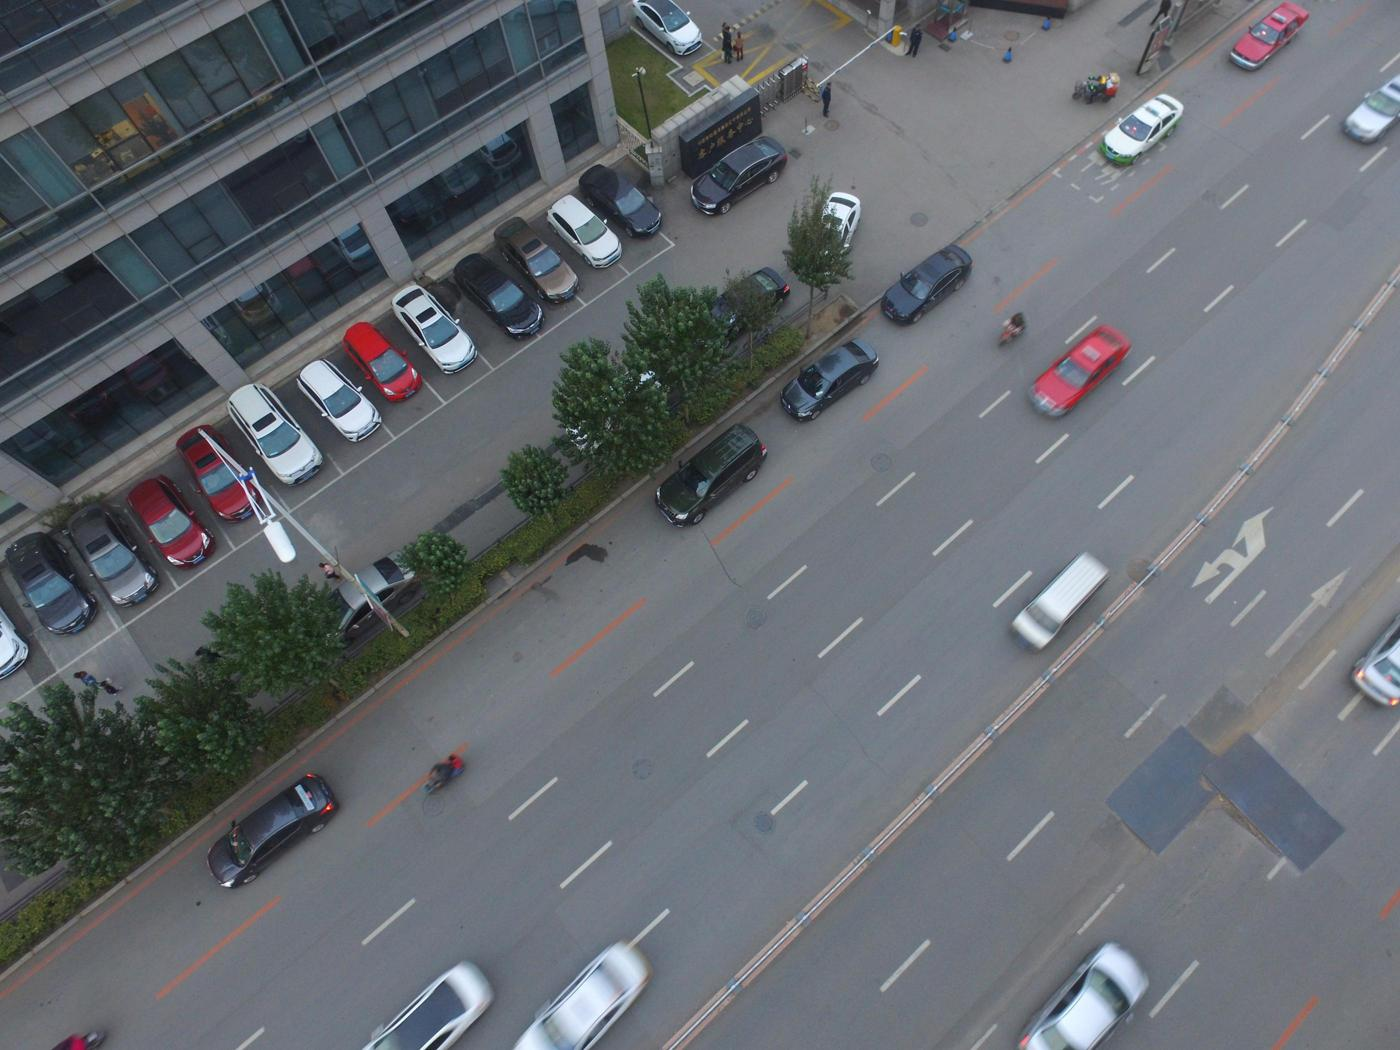

In [13]:
# select random image
image_id = random.randint(0, len(TRAIN_DATASET.image_list) - 1)
print('Image #{}'.format(image_id))

# load image
image_path = os.path.join(TRAIN_IMAGE_DIRECTORY, TRAIN_DATASET.image_list[image_id])
image = cv2.imread(image_path)

# display image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
# load image and annotations
image_path = os.path.join(TRAIN_IMAGE_DIRECTORY, TRAIN_DATASET.image_list[image_id])
annotation_path = os.path.join(TRAIN_ANNOTATION_DIRECTORY, os.path.splitext(TRAIN_DATASET.image_list[image_id])[0] + ".txt")

image = cv2.imread(image_path)

In [15]:
# read annotations
with open(annotation_path, 'r') as file:
    annotations = file.read()

In [26]:
# annotate
detections = sv.Detections.from_coco_annotations(annotations)

AttributeError: type object 'Detections' has no attribute 'from_coco_annotations'

In [ ]:






# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

# show annotated image
%matplotlib inline
sv.show_image(image, frame, (8, 8))
